# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_json("./Software_5.json", lines=True)


The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote

In [25]:
dataframe = dataframe[dataframe['vote'].notna()]


For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [26]:
from nltk.corpus import stopwords
import nltk
import string
import contractions


def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)


dataframe["processed_review"] = dataframe["reviewText"].apply(lower_text).apply(expand_contraction).apply(
    remove_stop_words).apply(remove_special_symbol).apply(stemming)


[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date

Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive

In [27]:
def sentiment_from_overall(number):
    if number < 3.0:
        return -1
    if number == 3.0:
        return 0
    return 1

dataframe["sentiment"] = dataframe["overall"].apply(sentiment_from_overall)

# Visualization

Exploratory data analysis on overall rating column

In [28]:
dataframe["overall"].describe()


count    3902.000000
mean        3.367760
std         1.557351
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64

Plotting pie chart and bar chart for overall score distribution. The 'overall' column has 5 labels: 1.0, 2.0, 3.0, 4.0, 5.0 where 1.0 is very bad, 3.0 is neutral and 5.0 is very good.

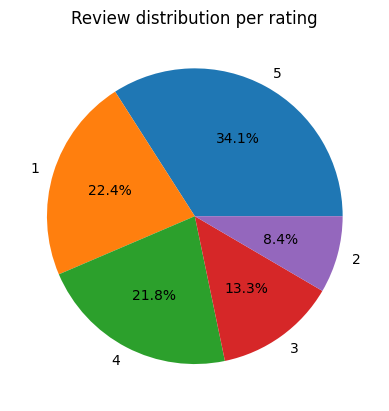

<AxesSubplot: title={'center': 'Review count per rating'}>

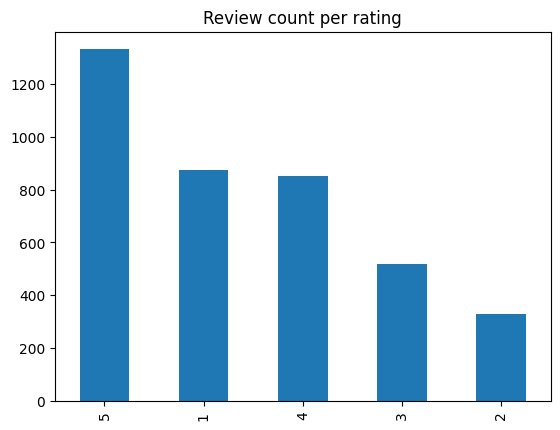

In [29]:
scores = dataframe["overall"].value_counts()
index = scores.index.to_numpy()
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per rating")
plt.show()
dataframe['overall'].value_counts().plot(kind='bar',title="Review count per rating")


We get the same statistic, but this time with sentiment

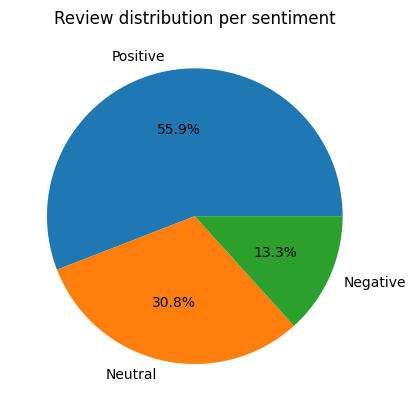

<AxesSubplot: title={'center': 'Review count per sentiment'}>

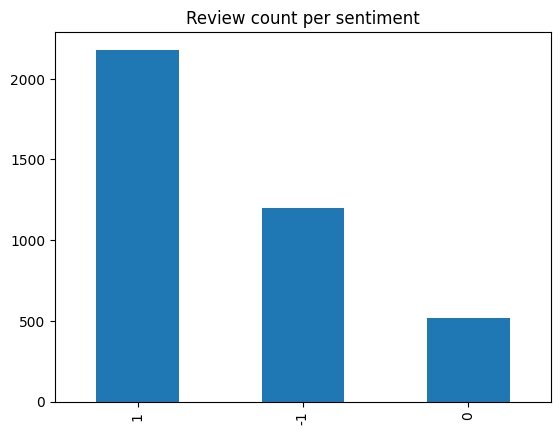

In [30]:
def sentiment_to_word(number):
    if number == 1:
        return "Positive"
    if number == 0:
        return "Negative"
    return "Neutral"

scores = dataframe["sentiment"].value_counts()
index = [sentiment_to_word(x) for x in scores.index.to_numpy()]
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per sentiment")
plt.show()
dataframe['sentiment'].value_counts().plot(kind='bar',title="Review count per sentiment")


Now, we get statistics on reivewText length. To visualize this, we use a boxplot

Statistic of text length
 count     3902.000000
mean      1137.915428
std       1409.747266
min          3.000000
25%        361.000000
50%        734.000000
75%       1428.500000
max      23075.000000
Name: processed_review, dtype: float64


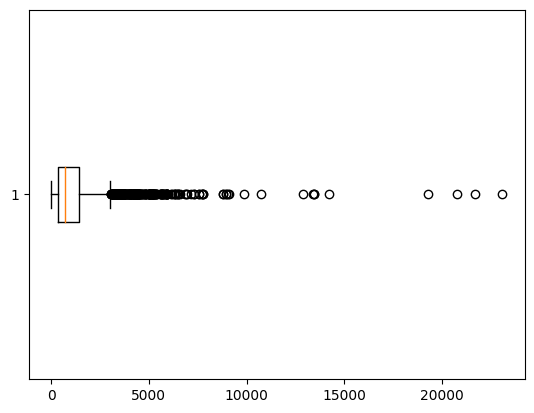

In [31]:
text_length = dataframe["processed_review"].apply(len)
print("Statistic of text length\n", text_length.describe())
# To visualize this, we use boxplot
plt.boxplot(text_length, vert=False)
plt.show()


Wordcloud to visualize top words in our `processed_review` column

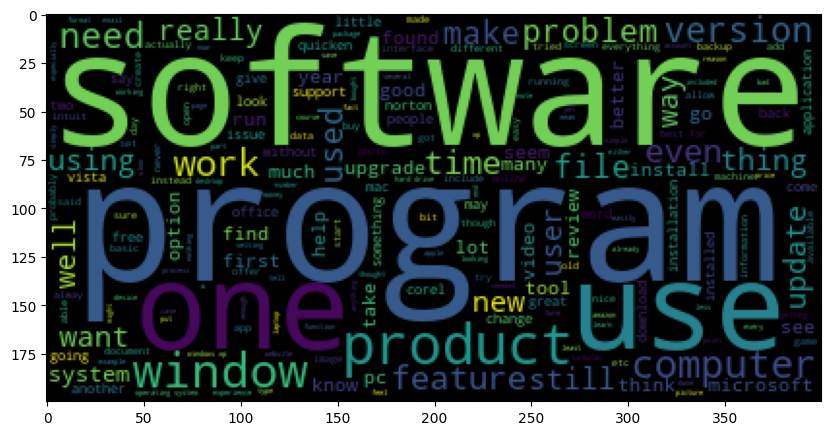

In [32]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(dataframe['processed_review']))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud)
